# Deep Neural Learning and Bayesian Optimization of Hyperparameters

## Mohammad Ali Zamani
### Senior Machine Learning Scientist
 [zamani.ai](https://zamani.ai)


---
 
some parts taken from: https://pytorch.org/tutorials/

more about AutoML: https://www.automl.org/


In [1]:
!pip install hpbandster
!wget -nc "https://github.com/YoongiKim/CIFAR-10-images/archive/master.zip"
!unzip -n master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
File ‘master.zip’ already there; not retrieving.

Archive:  master.zip
d7d05618061fe37d830fb0419063d113c575ccbc


In [2]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import numpy as np
import os
import gzip
from torch.utils.data import Dataset 
from torchvision import transforms
import torch
import pickle
from tqdm import tqdm
from skimage import io
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def build_cifar_path_label(set_type, training_sample_num):
    dataset_path = 'CIFAR-10-images-master'
    label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
    images_path = []
    label_num = []

    if set_type == 'train':
        if training_sample_num == -1:
            sample_num = 4500.
        else:
            sample_num = training_sample_num / 10
        for i in range(len(label_name)):
            for j in range(int(sample_num)):
                images_path.append(os.path.join(dataset_path, 'train', label_name[i], str(j).zfill(4) + '.jpg'))
                label_num.append(i)
    
    elif set_type == 'val':
        for i in range(len(label_name)):
            for j in range(4500,5000):
                images_path.append(os.path.join(dataset_path, 'train', label_name[i], str(j).zfill(4) + '.jpg'))
                label_num.append(i)

    elif set_type == 'test':
        for i in range(len(label_name)):
            for j in range(1000):
                images_path.append(os.path.join(dataset_path, 'test', label_name[i], str(j).zfill(4) + '.jpg'))
                label_num.append(i)

    return images_path, label_num

class MyDataSet(Dataset):
    def __init__(self, set_type, training_sample_num, data_transforms):
        super(MyDataSet, self).__init__()
    	
        images_path, labels = build_cifar_path_label(set_type, training_sample_num)

        images = np.zeros((len(labels), 32, 32, 3), dtype=np.uint8)
        for i in tqdm(range(len(images_path))):
            images[i, :, :, :] = io.imread(images_path[i])
           
        self.input = images
        self.label = np.asarray(labels)
        self.transform = data_transforms

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.transform(transforms.ToPILImage()(self.input[idx])), self.label[idx]

In [4]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

class Optimization():
    def __init__(self, args, loss,  train_loader, val_loader, test_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        device = args.device
        self.args = args
        self.model = CNN(args).to(device)
        
        print("number of trainable parameter = ", count_parameters(self.model))
        
        if args.optimizer == 'Adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=args.rate)
        elif args.optimizer == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=args.rate, momentum=args.sgd_momentum)

        self.scheduler = StepLR(self.optimizer, step_size=args.lr_decay_step)

        self.loss = loss
        self.device = device

    def train(self):
        batch_counter = 0.0
        total_loss = 0.0
        self.model.train()
        for iter, data in enumerate(self.train_loader):
            
            inputs, labels = data 

            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.model.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss(outputs, labels)
            loss.backward()

            self.optimizer.step()

            batch_counter += 1
            total_loss += loss.item()
            
        loss_value = total_loss / batch_counter
        return loss_value

    def val_eval(self):
        batch_counter = 0.0
        total_loss = 0.0
        self.model.eval()
        for iter, data in enumerate(self.val_loader):
            inputs, labels = data
            
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            
            # for evaluating the network, we disable the gradient calculation with the no_grad function
            with torch.no_grad():
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels)

            batch_counter += 1
            total_loss += loss.item()

        loss_value = total_loss / batch_counter
        return loss_value

    def test_eval(self, graph=False):
        total= 0.0
        correct = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        self.model.eval()

        for iter, data in enumerate(self.test_loader):
            inputs, labels = data
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
           
            # for evaluating the network, we disable the gradient calculation with the no_grad function
            with torch.no_grad():
                outputs = self.model(inputs)
                _ , predicted = torch.max(outputs, 1)
                result = (predicted == labels)
                total += labels.size(0)
                correct += result.sum().item()

                c = result.squeeze()
                for i in range(labels.shape[0]):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
         
        test_acc = correct / total
        
        print()
        for i in range(10): 
            print('%s: %2d%%,' % (classes[i], 100 * class_correct[i] / class_total[i]), end =" ")
        print()
        
        return test_acc

In [5]:
import copy

def main(args, train_loader, val_loader, test_loader):
    device = torch.device(args.device)
    best_val_error = np.inf

    if args.loss == 'NLL':
        loss_function = nn.NLLLoss(reduction='mean')
    elif args.loss == 'CE':
        loss_function = nn.CrossEntropyLoss(reduction='mean')
        nn.CrossEntropyLoss

    optimization = Optimization(args, loss_function, train_loader, val_loader, test_loader)

    train_loss_records = []
    val_loss_records = []
    test_loss_records = []

    print("loading training, val and test set completed!")
    mistake_counter = 0  # mistakes counter for validation loss

    for epoch in range(args.epochs):
        train_loss = optimization.train()
        train_loss_records.append(train_loss)
        optimization.scheduler.step()

        val_loss = optimization.val_eval()
        val_loss_records.append(val_loss)

        test_loss = optimization.test_eval()
        test_loss_records.append(test_loss)

        if epoch > 1:
            if val_loss_records[-1] > val_loss_records[-2]:
                mistake_counter += 1

        if val_loss < best_val_error:
            best_results = {
                'epoch': epoch + 1,
                'state_dict': copy.deepcopy(optimization.model.state_dict()),
                'model': optimization.model,
                'best_val_error': val_loss,
                'best_test_error': test_loss,
                'optimizer': copy.deepcopy(optimization.optimizer),
                'args': args
            }
            best_val_error = val_loss
        print(
            '[Epoch: %3d/%3d] LR: %0.8f  Train loss: %.4f,    Val loss: %.4f,   Test Acc: %.4f'
            % (epoch + 1, args.epochs, optimization.scheduler.get_lr()[0], train_loss_records[epoch], val_loss_records[epoch],
               test_loss_records[epoch]))
        
        if mistake_counter >= args.tol or epoch == args.epochs - 1:
            print('Training is terminated')
            break
    return test_loss, val_loss

In [6]:
from typing import NamedTuple
class Args(NamedTuple):
    rate: float  # learning rate
    lr_decay_step: int  # learning rate decay
    batch_size: int  # minibatch size
    epochs: int  # maximum training epochs
    sample_num: int  # number of sample to be loaded
    tol: int  # tolerance for the validation error increment
    device: str  # cuda or cpu
    loss: str  # loss function     
    optimizer: str # optimizer method
    sgd_momentum: float #

    dropout: float  # the probability for dropout 
    fc1: int # 1st hidden layer's units
    fc2: int
    cout1: int
    cout2: int
    cout3: int
    cout4: int
    ks1: int
    # TODO: add more layers if necessary

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, args):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, args.cout1, args.ks1, 1, int(np.ceil((args.ks1-1)/2)))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(args.cout1, args.cout2, 3, 1, 1)
        self.conv3 = nn.Conv2d(args.cout2, args.cout3, 3, 1, 1 )
        self.conv4 = nn.Conv2d(args.cout3, args.cout4, 3, 1, 1)
        self.fc1 = nn.Linear(2*2*args.cout4, args.fc1)
        self.fc2 = nn.Linear(args.fc1, args.fc2)
        self.fc3 = nn.Linear(args.fc2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# for hyperparameter optimization
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB
import logging
logging.basicConfig(level=logging.INFO)

class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.batch_size = 128
        self.sample_num = 4500

        self.data_transforms = {
            'train': transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(5),
                transforms.ColorJitter(
                    brightness=0.1,
                    contrast=0.1,
                    saturation=0.1,
                    hue=0.1),
                transforms.RandomCrop((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.CenterCrop((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.CenterCrop((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
        }

        training_set = MyDataSet(set_type='train', training_sample_num=self.sample_num, data_transforms=self.data_transforms['train'])
        val_set = MyDataSet(set_type='val', training_sample_num=None, data_transforms=self.data_transforms['val'])
        test_set = MyDataSet(set_type='test', training_sample_num=None, data_transforms=self.data_transforms['test'])

        self.train_loader = DataLoader(training_set, batch_size=self.batch_size, num_workers=8, shuffle=True, drop_last=False)
        self.val_loader = DataLoader(test_set, batch_size=self.batch_size, num_workers=8, shuffle=False, drop_last=True)
        self.test_loader = DataLoader(test_set, batch_size=self.batch_size, num_workers=8, shuffle=False, drop_last=True)

    def compute(self, config, budget, working_directory, *args, **kwargs):
        """
        testing the configuration
        """
        print("Selected HyperParameters to test: ")
        print(config)
        new_args = Args(
                        rate=config['lr'],
                        lr_decay_step=100,
                        batch_size=self.batch_size,
                        epochs=int(budget),
                        sample_num = self.sample_num,
                        tol=100,
                        loss='CE',
                        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),

                        optimizer= 'Adam',
                        sgd_momentum= 0.0,
                        dropout= config['dropout'],
                        fc1=config['fc1'], # 
                        fc2=config['fc2'],
                        cout1=config['cout1'],
                        cout2=config['cout2'],
                        cout3=config['cout3'],
                        cout4=config['cout4'],
                        ks1=config['ks1']
                        # TODO2 add the additional parameters from Args class here
                        )

        test_acc, val_loss = main(new_args, self.train_loader, self.val_loader, self.test_loader)
        return ({
            'loss': val_loss,  # remember: HpBandSter always minimizes!
            'info': {'test accuracy': test_acc,
                     }
        })

    
    @staticmethod
    def get_configspace():
        """
            It builds the configuration space with the needed hyperparameters
            :return: ConfigurationsSpace-Object
            """
        cs = CS.ConfigurationSpace()

        # TODO3: add a proper condition here
 
        lr = CSH.UniformFloatHyperparameter('lr', lower=1e-4, upper=1e-1, default_value='1e-2', log=True)
        cs.add_hyperparameters([lr])

        # Type 4 condition: Integer
        fc1 = CSH.UniformIntegerHyperparameter('fc1', lower=50, upper=200, default_value=100, log=False)
        fc2 = CSH.UniformIntegerHyperparameter('fc2', lower=20, upper=80, default_value=50, log=False)

        cs.add_hyperparameters([fc1, fc2])

        cout1 = CSH.UniformIntegerHyperparameter('cout1', lower=8, upper=32, default_value=16, log=False)
        cout2 = CSH.UniformIntegerHyperparameter('cout2', lower=8, upper=32, default_value=16, log=False)
        cout3 = CSH.UniformIntegerHyperparameter('cout3', lower=8, upper=32, default_value=16, log=False)
        cout4 = CSH.UniformIntegerHyperparameter('cout4', lower=8, upper=32, default_value=16, log=False)
        
        cs.add_hyperparameters([cout1, cout2, cout3, cout4])

        dropout = CSH.UniformFloatHyperparameter('dropout', lower=0.0, upper=0.9, default_value=0.1, log=False)
        cs.add_hyperparameters([dropout])

        ks1 = CSH.UniformIntegerHyperparameter('ks1', lower=3, upper=6, default_value=3, log=False)
        cs.add_hyperparameters([ks1])

        return cs

In [9]:
# TO record a backup from the old hyperparamter searches
def backup_jsons(curDir):
    for fname in ('results', 'configs'):
        if os.path.exists(curDir + os.path.sep + fname + '.json'):
            counter = 1
            while os.path.exists(curDir + os.path.sep + fname + '_' + str(counter) + '.json'):
                counter += 1
            os.rename(curDir + os.path.sep + fname + '.json', curDir + os.path.sep + fname + '_' + str(counter) + '.json')


args_min_budget = 1 # Minimum number of epochs for training.
args_max_budget = 9 # Maximum number of epochs for training.
args_n_iterations = 1 # Number of iterations performed by the optimizer
args_worker = False # Flag to turn this into a worker process
args_run_id = '' # A unique run id for this optimization run. An easy option is to use the job id of the clusters scheduler.
args_nic_name = 'lo' # Which network interface to use for communication.
args_shared_directory = '.' # A directory that is accessible for all processes, e.g. a NFS share.
args_eta = 3 # eta

# Every process has to lookup the hostname
host = hpns.nic_name_to_host(args_nic_name)


if args_worker:
    import time
    time.sleep(1)   # short artificial delay to make sure the nameserver is already running
    w = PyTorchWorker(run_id=args_run_id, host=host, timeout=120)
    w.load_nameserver_credentials(working_directory=args_shared_directory)
    w.run(background=False)
    exit(0)


# This example shows how to log live results. This is most useful
# for really long runs, where intermediate results could already be
# interesting. The core.result submodule contains the functionality to
# read the two generated files (results.json and configs.json) and
# create a Result object.

#backup_jsons(args_shared_directory)
result_logger = hpres.json_result_logger(directory=args_shared_directory, overwrite=True)

# Start a nameserver:
NS = hpns.NameServer(run_id=args_run_id, host=host, port=0, working_directory=args_shared_directory)
ns_host, ns_port = NS.start()

# Start local worker
w = PyTorchWorker(run_id=args_run_id, host=host, nameserver=ns_host, nameserver_port=ns_port, timeout=120)
w.run(background=True)

# Run an optimizer
bohb = BOHB(  configspace = PyTorchWorker.get_configspace(),
                        run_id = args_run_id,
                        eta = args_eta,
                        host=host,
                        nameserver=ns_host,
                        nameserver_port=ns_port,
                        result_logger=result_logger,
                        min_budget=args_min_budget, 
                        max_budget=args_max_budget,
                        
                        # in case of expecting better result change the following 
                        num_samples = 32, # 1st decrease
                        top_n_percent=25, # 2nd increase 
                        bandwidth_factor=10, # 3rd increase or/and
                        min_bandwidth=1e-3, # 3rd increase
            
               )
res = bohb.run(n_iterations=args_n_iterations)

# store results
with open(os.path.join(args_shared_directory, 'results.pkl'), 'wb') as fh:
    pickle.dump(res, fh)

# shutdown
bohb.shutdown(shutdown_workers=True)
NS.shutdown()

100%|██████████| 10000/10000 [00:07<00:00, 1400.46it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Selected HyperParameters to test: 
{'cout1': 14, 'cout2': 18, 'cout3': 23, 'cout4': 13, 'dropout': 0.62176899822779, 'fc1': 117, 'fc2': 74, 'ks1': 4, 'lr': 0.002647862065496716}
number of trainable parameter =  25108
loading training, val and test set completed!

plane: 30%, car: 43%, bird:  0%, cat:  0%, deer:  0%, dog: 22%, frog: 83%, horse: 22%, ship: 29%, truck: 24%, 
[Epoch:   1/  1] LR: 0.00264786  Train loss: 2.1571,    Val loss: 2.0370,   Test Acc: 0.2564
Training is terminated
Selected HyperParameters to test: 
{'cout1': 12, 'cout2': 11, 'cout3': 20, 'cout4': 16, 'dropout': 0.7225418640916027, 'fc1': 63, 'fc2': 77, 'ks1': 6, 'lr': 0.00034299661310539234}
number of trainable parameter =  17206
loading training, val and test set completed!


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



plane:  0%, car:  0%, bird:  0%, cat: 85%, deer:  0%, dog:  0%, frog:  0%, horse: 19%, ship:  0%, truck:  0%, 
[Epoch:   1/  1] LR: 0.00034300  Train loss: 2.3025,    Val loss: 2.2969,   Test Acc: 0.1063
Training is terminated
Selected HyperParameters to test: 
{'cout1': 23, 'cout2': 28, 'cout3': 28, 'cout4': 12, 'dropout': 0.16770267183187637, 'fc1': 119, 'fc2': 34, 'ks1': 6, 'lr': 0.03114342262343905}
number of trainable parameter =  28712
loading training, val and test set completed!

plane:  0%, car:  0%, bird:  0%, cat: 100%, deer:  0%, dog:  0%, frog:  0%, horse:  0%, ship:  0%, truck:  0%, 
[Epoch:   1/  1] LR: 0.03114342  Train loss: 2.6176,    Val loss: 2.3087,   Test Acc: 0.1002
Training is terminated
Selected HyperParameters to test: 
{'cout1': 29, 'cout2': 26, 'cout3': 11, 'cout4': 11, 'dropout': 0.09685790596616882, 'fc1': 180, 'fc2': 74, 'ks1': 3, 'lr': 0.014761977215336444}
number of trainable parameter =  33553
loading training, val and test set completed!

plane: 36%,

Best found configuration:
{'cout1': 14, 'cout2': 18, 'cout3': 23, 'cout4': 13, 'dropout': 0.62176899822779, 'fc1': 117, 'fc2': 74, 'ks1': 4, 'lr': 0.002647862065496716}
It achieved validation loss of 1.582353 and test accuracy of 0.419671 .


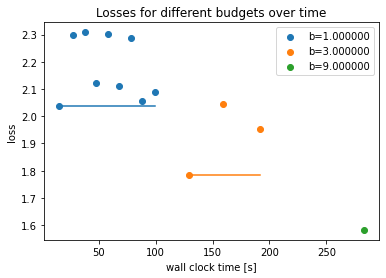

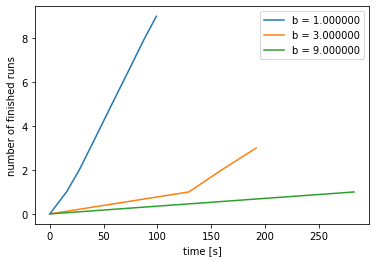

In [10]:
import matplotlib.pyplot as plt
import hpbandster.core.result as hpres
import hpbandster.visualization as hpvis

# load the example run from the log files
result = hpres.logged_results_to_HBS_result('.')

# get all executed runs
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()


# Here is how you get he incumbent (best configuration)
inc_id = result.get_incumbent_id()

# let's grab the run on the highest budget
inc_runs = result.get_runs_by_id(inc_id)
inc_run = inc_runs[-1]


# We have access to all information: the config, the loss observed during
#optimization, and all the additional information
inc_loss = inc_run.loss
inc_config = id2conf[inc_id]['config']
inc_test_loss = inc_run.info['test accuracy']

print('Best found configuration:')
print(inc_config)
print('It achieved validation loss of %f and test accuracy of %f .'%(inc_loss, inc_test_loss))


# Let's plot the observed losses grouped by budget,
hpvis.losses_over_time(all_runs)

# and the number of finished runs.
hpvis.finished_runs_over_time(all_runs)


plt.show()